# Read-out Error


In [4]:
# import packages
import numpy as np

import qiskit_aer.noise as noise
from qiskit_aer.noise.errors import coherent_unitary_error, amplitude_damping_error, ReadoutError
from qiskit.circuit.library import RXGate

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

In [5]:
def get_readout_error_matrix(X):
    """
    args:
        X: np.darray (Nx2) probability of false result from most to least significant bit
    returns:
        output: np.darray (2^N x 2^N) matrix of readout errors
    """
    # cast to np array
    try:
        X = np.array(X)
    except Exception as exception:
        print("Must pass in valid datatype: array of numbers.")
        print(exception)
    
    # check array dimensions
    D = X.shape[1]
    if D != 2:
        raise ValueError("Input probabilities must be in form [[probability of error when prepared 0, probability of error when prepared 1], ...]")

    # number data points
    N = X.shape[0]

    output = np.ones((1, 1))

    SIGN = np.array([[-1, 1], [1, -1]])

    # goal shape: 2^N x 2^N
    for i in range(N):
        # obtain confusion matrix
        p_i = X[i].reshape((2, 1)) # [[FN], [FP]]
        p_i = p_i * SIGN # [[-FN, FN], [FP, -FP]]
        p_i = p_i + np.eye(2) # [[TN, FN], [FP, TP]]

        # reshape matrices
        p_i_flattened = p_i.reshape((1, p_i.size))

        # recursively calculate dimensions
        output_new = np.ones((2 * output.shape[0], 2 * output.shape[0])) 

        # i
        for j in range(output.shape[0]):
            row = output[j].reshape((output[j].size, 1))

            prod = row * p_i_flattened # shape output[j].size x 4
            output_new[(2 * j)] = prod[:, 0:2].flatten()
            output_new[(2 * j + 1)] = prod[:, 2:4].flatten()

        output = output_new

    return output

In [6]:
probabilities = [
    [0.01, 0.03]
]
get_readout_error_matrix(probabilities)

array([[0.99, 0.01],
       [0.03, 0.97]])

In [7]:
probabilities = [
    [0.01, 0.03],
    [0.05, 0.02]
]
get_readout_error_matrix(probabilities)

array([[9.405e-01, 4.950e-02, 9.500e-03, 5.000e-04],
       [1.980e-02, 9.702e-01, 2.000e-04, 9.800e-03],
       [2.850e-02, 1.500e-03, 9.215e-01, 4.850e-02],
       [6.000e-04, 2.940e-02, 1.940e-02, 9.506e-01]])

In [8]:
def string_to_int_array(X):
    return np.array(list(X)).astype("i")

In [9]:
def get_probabilities_of_one(data):
	"""
	args:
		data (dict) dictionary of {"outcome": counts}

	returns:
		probabilities (1xN array) the value at index i is the probability of measuring a 1
	"""

	N = len(list(data.keys())[0])
	
	total_counts = np.zeros(N)

	for key in list(data.keys()):
		counts = data[key]

		arr = string_to_int_array(key)
		
		total_counts = total_counts + (counts * arr)
	
	nshots = np.sum(list(data.values()))

	probabilities = total_counts / nshots

	return probabilities

## Basic Readout Error

We consider a simple case of read-out error mitigation.

In [10]:
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.noise import NoiseModel

backend = AerSimulator.from_backend(FakePerth())

In [11]:
N = 7

zeros = QuantumCircuit(N)
zeros.measure_all()

ones = QuantumCircuit(N)
ones.x(list(range(N)))
ones.measure_all()

In [45]:
zeros.draw()

░ ┌─┐                  
   q_0: ─░─┤M├──────────────────
         ░ └╥┘┌─┐               
   q_1: ─░──╫─┤M├───────────────
         ░  ║ └╥┘┌─┐            
   q_2: ─░──╫──╫─┤M├────────────
         ░  ║  ║ └╥┘┌─┐         
   q_3: ─░──╫──╫──╫─┤M├─────────
         ░  ║  ║  ║ └╥┘┌─┐      
   q_4: ─░──╫──╫──╫──╫─┤M├──────
         ░  ║  ║  ║  ║ └╥┘┌─┐   
   q_5: ─░──╫──╫──╫──╫──╫─┤M├───
         ░  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_6: ─░──╫──╫──╫──╫──╫──╫─┤M├
         ░  ║  ║  ║  ║  ║  ║ └╥┘
meas: 7/════╩══╩══╩══╩══╩══╩══╩═
            0  1  2  3  4  5  6

In [46]:
ones.draw()

┌───┐ ░ ┌─┐                  
   q_0: ┤ X ├─░─┤M├──────────────────
        ├───┤ ░ └╥┘┌─┐               
   q_1: ┤ X ├─░──╫─┤M├───────────────
        ├───┤ ░  ║ └╥┘┌─┐            
   q_2: ┤ X ├─░──╫──╫─┤M├────────────
        ├───┤ ░  ║  ║ └╥┘┌─┐         
   q_3: ┤ X ├─░──╫──╫──╫─┤M├─────────
        ├───┤ ░  ║  ║  ║ └╥┘┌─┐      
   q_4: ┤ X ├─░──╫──╫──╫──╫─┤M├──────
        ├───┤ ░  ║  ║  ║  ║ └╥┘┌─┐   
   q_5: ┤ X ├─░──╫──╫──╫──╫──╫─┤M├───
        ├───┤ ░  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_6: ┤ X ├─░──╫──╫──╫──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║  ║  ║  ║ └╥┘
meas: 7/═════════╩══╩══╩══╩══╩══╩══╩═
                 0  1  2  3  4  5  6

In [12]:
# run the circuit on the simulator
backend = FakePerth()
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(options={
    'backend_options': {
        'noise_model': noise_model
	}
})
nshots = 1024

zeros_transpiled = transpile(zeros, backend)
zeros_job = sampler.run([zeros_transpiled], shots=nshots)
zeros_pub_result = zeros_job.result()[0]

zeros_counts = zeros_pub_result.data.meas.get_counts()


ones_transpiled = transpile(ones, backend)
ones_job = sampler.run([ones_transpiled], shots=nshots)
ones_pub_result = ones_job.result()[0]

ones_counts = ones_pub_result.data.meas.get_counts()

In [13]:
ones_false_probs = 1 - get_probabilities_of_one(ones_counts)
zeros_false_probs = get_probabilities_of_one(zeros_counts)

In [14]:
# calculate the read-out matrix
zipped = np.array([zeros_false_probs, ones_false_probs]).T
error_matrix = get_readout_error_matrix(zipped)

In [16]:
# get the readout error mitigation matrix
mitigation_matrix = np.linalg.inv(error_matrix.T)

In [63]:
def to_string(x, N):
	return str(bin(x)).replace("0b", "").zfill(N)

def to_vector(counts):
	""" 
	Returns a vector of the counts, where the ith position is number of counts for result 0bi.

	"""
	N = len(list(counts.keys())[0])
	keys = list(counts.keys())

	vector = np.zeros(2**N)
	
	for i in range(0, 2**N):
		key = to_string(i, N)

		if key in keys:
			vector[i] = counts[key]

	return vector

def to_dict(vector):
	counts = {}
	total_states = vector.shape[0]
	N = int(np.log2(total_states))

	for i in range(0, total_states):
		key = to_string(i, N)
		value = round(vector[i])
		if value != 0:
			counts[key] = round(vector[i])

	return counts

## Testing

In [57]:
# define the circuit
from qiskit.circuit.random import random_circuit

nshots = 1024
 
# generate a random circuit
circuit = random_circuit(N, 1, measure=True)
circuit.draw()

┌───────┐┌─┐                  
q_0: ┤0      ├┤M├──────────────────
     │       │└╥┘┌─┐               
q_1: ┤1 Rccx ├─╫─┤M├───────────────
     │       │ ║ └╥┘┌─┐            
q_2: ┤2      ├─╫──╫─┤M├────────────
     └─┬────┬┘ ║  ║ └╥┘┌─┐         
q_3: ──┤ Sx ├──╫──╫──╫─┤M├─────────
       └─┬──┘  ║  ║  ║ └╥┘┌─┐      
q_4: ────■─────╫──╫──╫──╫─┤M├──────
         │     ║  ║  ║  ║ └╥┘┌─┐   
q_5: ────■─────╫──╫──╫──╫──╫─┤M├───
         │     ║  ║  ║  ║  ║ └╥┘┌─┐
q_6: ────■─────╫──╫──╫──╫──╫──╫─┤M├
               ║  ║  ║  ║  ║  ║ └╥┘
c: 7/══════════╩══╩══╩══╩══╩══╩══╩═
               0  1  2  3  4  5  6

In [58]:
# get ideal results
ideal_backend = AerSimulator()

ideal_transpiled = transpile(circuit, ideal_backend)
ideal_result = ideal_backend.run(ideal_transpiled).result()
ideal_counts = ideal_result.get_counts(ideal_transpiled)
ideal_counts

{'0000000': 1024}

In [59]:
# get the noisy results
noisy_backend = FakePerth()
noise_model = NoiseModel.from_backend(noisy_backend)
sampler = Sampler(options={
    'backend_options': {
        'noise_model': noise_model
	}
})
nshots = 1024

noisy_transpiled = transpile(circuit, noisy_backend)
noisy_job = sampler.run([noisy_transpiled], shots=nshots)
noisy_pub_result = noisy_job.result()[0]
noisy_counts = noisy_pub_result.data.c.get_counts()

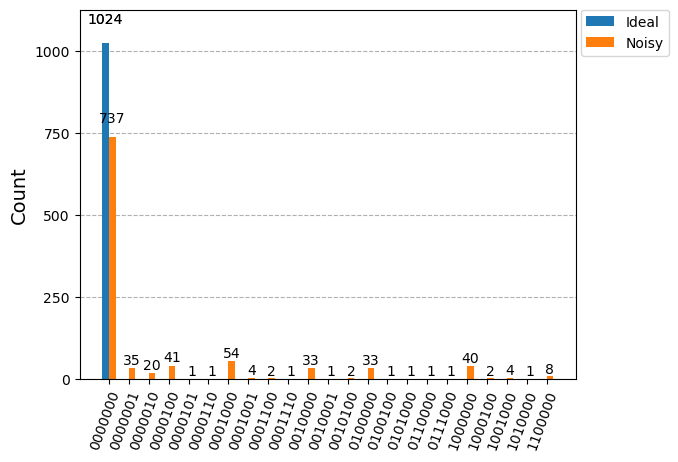

In [60]:
from qiskit.visualization import plot_histogram

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

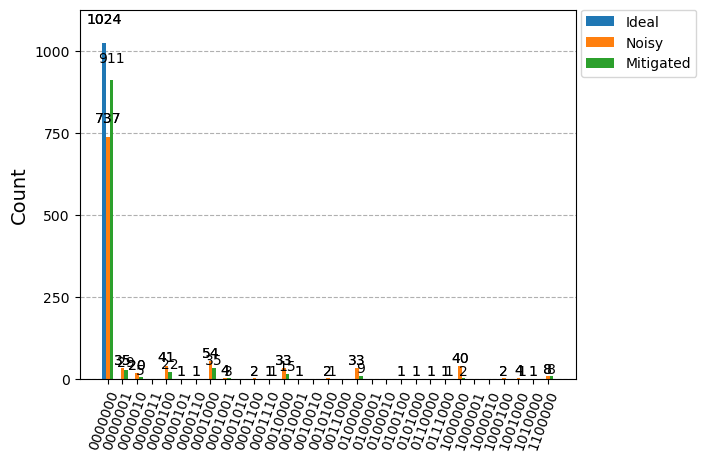

In [64]:
# mitigate the noisy results
noisy_probabilities = to_vector(noisy_counts) / nshots
mitigated_probabilities = mitigation_matrix @ noisy_probabilities
mitigated_counts = to_dict(mitigated_probabilities * nshots)

# plot mitigated versus ideal
plot_histogram([ideal_counts, noisy_counts, mitigated_counts], legend=["Ideal", "Noisy", "Mitigated"])

## Batch Readout Error Mitigation